In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from keras.utils import np_utils
from nltk.tokenize import RegexpTokenizer
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction import text as sktext
from sklearn import preprocessing as skp
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
from keras.engine import Layer
import keras.backend as K
from sklearn.metrics import f1_score
from keras.utils.vis_utils import model_to_dot
from keras import models
from keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D, Reshape
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import Constant


Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
df = pd.read_csv('final_data.csv')

In [4]:
df.head()

,Unnamed: 0,label,user,tweet,emb,text,lemmas
0,0,0,1615850780,929479629840281601,[ 0.00447152 -0.00207724 -0.00693714 -0.005786...,I am a young person and I am quite open to Pak...,i be muhajir aur mere lye sab se pehly pakista...
1,1,0,903075788756590593,929467030406758400,[ 0.00511213 0.0066199 -0.00406399 -0.001209...,<User> <User> Doctor Subhash ke PhD in Het Pol...,<user> <user> doctor sab sahi me ke phd in hat...
2,2,1,881096476616781825,929460995981901825,[-0.6831904 2.609242 2.6378176 2.580363...,"After the formation of the government, a singl...",<user> sarkar banne ke bad hindu hit me ek bhi...
3,3,1,3268145264,929460432498233344,[ 1.6771747 0.14684932 -0.8186511 1.882037...,Hate it when the test is not so frozen,hate it jab test ata ho phr bh acha na ho
4,4,0,763212669524467712,929459222697431040,[ 1.1214749 3.8859344 3.6560123 2.660346...,<user> One of the victims has been raped and r...,<user> ek dil ek jaan akal ke imitihaan kal kp...


In [5]:
df['label'] = df['label'].astype(int)

In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
train_df = pd.DataFrame()
train_df['content'] = df['lemmas']
train_df['class'] = df['label']

Training data phrase length distribution


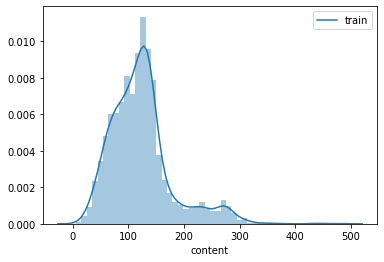

In [8]:
print("Training data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "train"})

In [9]:
print('Most frequent sentence length in training:')
lens = train_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in training:
134


Testing data phrase length distribution


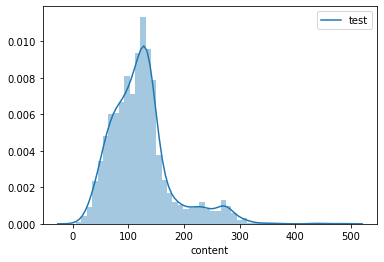

In [10]:
print("Testing data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [11]:
train_df.shape

(3475, 2)

In [12]:
test_df = train_df[2800:]
train_df = train_df[:2800]

Testing data phrase length distribution


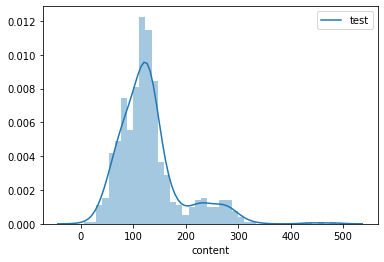

In [13]:
print("Testing data phrase length distribution")
sns.distplot(test_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [14]:
print('Most frequent sentence length in testing:')
lens = test_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in testing:
118


In [15]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [16]:

## A dictionary to map the punctuations present in the text to relevant strings or symbols
punct_mapping = {"‘": "'", 
                 "₹": "e", 
                 "´": "'", 
                 "°": "", 
                 "€": "e", 
                 "™": "tm",
                 "√": " sqrt ",
                 "×": "x",
                 "²": "2",
                 "—": "-",
                 "–": "-",
                 "’": "'",
                 "_": "-",
                 "`": "'",
                 '“': '"',
                 '”': '"',
                 '“': '"',
                 "£": "e",
                 '∞': 'infinity',
                 'θ': 'theta',
                 '÷': '/',
                 'α': 'alpha',
                 '•': '.',
                 'à': 'a',
                 '−': '-',
                 'β': 'beta',
                 '∅': '',
                 '³': '3',
                 'π': 'pi',
                 ',':'',
                 '.':'',
                 ':':'',
                 '(':'',
                 ')':'',
                 '*':'',
                '"':'',
                '<':'',
                '>':''}

In [17]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

## Function to remove special characters from the sentences (if any present)
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [18]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))

In [19]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [20]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [21]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))

In [22]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: text.lower())
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: text.lower())

In [23]:
data = train_df.values
data_test = test_df.values

In [24]:
X_train = data[:,0]
Y_train = data[:,1]

X_test = data_test[:,0]
Y_test = data_test[:,1]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print ("-------------------------")
print (X_test[0], Y_test[0])
print (X_train[0], Y_train[0])

(2800,) (2800,) (675,) (675,)
-------------------------
jaipur police be very bad becoz twenty-four gante bad bhi rape ke aik bhi aaropi pakd me nhi aaya 0
i be muhajir aur mere lye sab se pehly pakistan he agr ten lakh altaf jese leaders bh be zameen ki behurmati kren un sbko sar e aam phansi deni chahye proud to be a hashtag and hashtag 0


In [25]:
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

In [26]:
for ix in range(X_train.shape[0]):
    X_train[ix] = tokenizer.tokenize(X_train[ix])
    X_train[ix] = [lemmatizer.lemmatize(i) for i in X_train[ix]]
    
for ix in range(X_test.shape[0]):
    X_test[ix] = tokenizer.tokenize(X_test[ix])
    X_test[ix] = [lemmatizer.lemmatize(i) for i in X_test[ix]]

In [27]:

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
#     print(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
## Length of the list of unique_words gives the no of unique words
print("Vocabulary Size:")
print(len(list(unique_words)))
print("Maximum length of sentence:")
print(len_max)

100%|██████████| 2800/2800 [00:00<00:00, 600319.54it/s]

Vocabulary Size:
10736
Maximum length of sentence:
72


In [28]:
tokenizer_keras = Tokenizer(num_words=len(list(unique_words)))
tokenizer_keras.fit_on_texts(list(X_train))
X_train = tokenizer_keras.texts_to_sequences(X_train)
X_test = tokenizer_keras.texts_to_sequences(X_test)

## Padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
## Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_test.shape)

(2800, 72) (675, 72)


In [29]:
embeddings_index = dict()

In [30]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [31]:
model = Word2Vec.load("word2vec.model")

In [32]:
word_vectors = model.wv

In [33]:
print(data[:,0])

[list(['i', 'be', 'muhajir', 'aur', 'mere', 'lye', 'sab', 'se', 'pehly', 'pakistan', 'he', 'agr', 'ten', 'lakh', 'altaf', 'jese', 'leader', 'bh', 'be', 'zameen', 'ki', 'behurmati', 'kren', 'un', 'sbko', 'sar', 'e', 'aam', 'phansi', 'deni', 'chahye', 'proud', 'to', 'be', 'a', 'hashtag', 'and', 'hashtag'])
 list(['user', 'user', 'doctor', 'sab', 'sahi', 'me', 'ke', 'phd', 'in', 'hate', 'politics', 'wale', 'bhai', 'padhe', 'likhe', 'ho', 'fir', 'kyu', 'ye', 'sab', 'baate', 'karte', 'ho', 'tum', 'ba', 'bowl', 'khelo', 'aur', 'maje', 'lo', 'url'])
 list(['user', 'sarkar', 'banne', 'ke', 'bad', 'hindu', 'hit', 'me', 'ek', 'bhi', 'faisla', 'jo', 'bjp', 'ke', 'dwara', 'liya', 'gaya', 'hobjp', 'ko', 'gaygobarmandirmasjid', 'aur', 'nafrat', 'faila', 'kar', 'vot', 'chahiye'])
 ...
 list(['user', 'user', 'be', 'rohit', 'ji', 'kabhi', 'bjp', 'se', 'bhi', 'puchh', 'lo', 'kaha', 'terrorism', 'kam', 'ho', 'gaya', 'sucide', 'kam', 'ho', 'gaye', 'url'])
 list(['user', 'aisi', 'hi', 'koi', 'baat', 'hindu

In [34]:
embeddings_index = dict()

In [35]:
for sent in data[:,0]:
    for token in sent:
        word = token
        word = lemmatizer.lemmatize(word)
        try:
            coefs = np.asarray(word_vectors[word], dtype='float32')
#             print(coefs)
#             print(coefs.shape)
            embeddings_index[word] = coefs
        except:
            print(word)
            coefs = np.zeros((200,))
            embeddings_index[word] = coefs

lakh
altaf
behurmati
sar
likhe
baate
bowl
khelo
maje
faisla
dwara
hobjp
gaygobarmandirmasjid
vot
imitihaan
kp
leg
cinematic
liberty
rajput
shaan
gulaam
sentimental
peene
baadjiss
buniyad
sudrega
pok
kabootar
udao
goliyon
saaf
hiten
samjhte
hadh
madambahut
sochsamajhkr
tarq
purey
mahino
pahucha
hatredhai
kabipartitionramtemplegaumatabharatmaatakijai
vandematram
raastragan
premigaddaarbachche
bibiya
safar
tai
huey
tajmahal
atka
rem
emoji
emoji
nagini
ladla
fard
jurm
girftar
trail
saza
barun
chahega
shivani
muze
achchi
muze
opinion
sarhad
lakir
mita
jinna
sahab
neharu
khbri
bnta
karachi
panjabi
pathano
qatal
kerkay
onki
lashain
gaoon
bhaijti
mohajiro
kaykhilaf
milan
bela
hater
bigg
bos
contestant
relate
nhisirf
relate
haiwo
walikhabari
chabar
chabar
stone
miracle
imam
pathar
behta
saja
chaiya
honour
vishwas
beheno
chedege
kisine
tippani
kardi
vegere
dhamki
karto
hopeless
garib
daala
bacchan
province
fakhar
quota
system
jaisay
mohajiron
intr
sindh
industry
nationalise
hoi
punjabion
pukra
j

phela
rakhey
knowledge
dangouras
yad
honke
simple
kise
kise
soonsan
jaga
gulalai
gulalai
sar
jhuka
nawaqif
haitu
hailog
gaaliya
gula
lai
aysha
ahad
hamza
shahbaz
ameer
muqam
cal
nahen
jaipur
jain
shuda
lut
criminalwhat
jaey
poochy
aagy
kysi
guzray
drmms
barbaadi
ore
staapit
arjun
krne
kosish
bahaut
tarrah
ahli
ilzaam
lagwa
shayd
rutvik
jaiye
bhot
aasan
eh
kardo
bechen
eh
mahila
shayed
peechlee
janam
esi
icchaa
iskibjp
jeev
sayad
padhi
arth
rapper
gaata
kachara
pakhtoon
aparte
aaggg
kheen
kh
shahbaz
sherf
sunnly
leon
ilzam
lagana
dey
bhes
saghi
bheno
chodte
sewer
alisha
ahmad
waqat
mbin
qasim
filmo
dalte
vari
dekhda
achammai
vaisake
gatee
jiski
boley
behna
sleeveless
phena
lanat
hmari
gairatmand
qoum
haiinhy
kabba
bethi
faroshi
ilzam
karday
gayathiri
raisa
julie
enna
aarav
ah
oviya
pannama
irukka
gandagi
hojaye
jahalat
dikhate
thy
khula
tazad
gadhe
madical
chorti
nijum
raate
mone
pore
fale
asha
gulo
kotha
mone
pore
sobuj
path
mathe
tmr
chola
golo
viv
aryan
chaudhary
nahikoun
bolai
yalga

atharv
atharv
allava
karyakarta
khabar
khabar
naliyakand
inhe
quki
jinke
sunta
hnahi
kadr
nafrt
vha
swal
poore
zaroor
bjd
yanhape
booth
dakhal
kiyeaap
jadu
chalaea
odisha
lagu
chaehe
kemuslim
bachhi
insaniyat
hairight
tumharay
karz
ispr
peshawar
martyr
hugye
kehti
mota
maray
bekari
hotiaur
gardi
hoteus
naukri
jhanda
onko
samjaye
onka
laash
shnaakht
mushkil
lagbhag
daketi
gardi
corruption
garibo
atyachaar
cheer
thode
sakat
raipur
grp
javano
kosish
arop
period
waali
gadhe
ghanshyam
poochh
lijiye
badayu
kand
doshi
basanti
earphone
zameer
jag
dosro
jy
mosquito
bhedbhav
chooste
jaghan
apradh
rokne
liy
liy
hamein
grw
doon
cv
howi
itefaq
kerte
nahein
bradran
hamayat
phela
tumharay
karz
ispr
peshawar
martyr
sanjay
bhansali
lagne
bolne
hauz
khas
lolgayi
meinhatred
agent
mukdme
chahae
bhart
aatank
badhawa
data
suchai
krti
jooth
educate
holy
parho
samjho
jawo
mitr
bharka
particular
chuitiye
sakha
camp
hainok
disbelief
lootte
unhone
marvai
invent
bhansali
lagne
thaye
shauhar
imp
prachar
hadd
taal


pitne
badmedical
huajan
patharbaj
va
bam
feknewale
manavadhikar
lac
muwavja
inaam
pidit
safed
chutiyaik
aut
nakam
mohabbat
nashai
simple
redlight
banaega
racket
chalaega
dikhega
nadhandha
badaldo
sabh
chorousa
tadad
shade
izafajamhori
kartyaasma
khamosh
kiunwo
dosri
khamosh
kiun
hamaaara
kiyaa
acharya
wanha
julm
betiyo
maarti
adhe
haibt
reprt
reprt
rapsit
jarur
tri
pakistanio
pilloon
himmat
loc
tmki
bhagaie
haramzaday
kritya
ghalati
jaante
sadhu
ghalati
beard
vikash
siyasat
kanun
balatkar
rukni
atnk
failane
sehmti
himt
dabre
bahir
hachote
howa
qasoor
theye
hidmat
bulbul
aashiq
dari
gaddari
tokri
banaoki
hopahle
gireban
hailalu
konse
bagwan
chck
romeo
squad
gayaaur
mulayam
yadav
ladake
madhur
tmko
tmri
rajya
sabha
mn
jaegi
aarop
lge
bht
imp
ladkiyan
haiaaye
poocha
kosis
nahe
hizda
ali
uworld
horahi
chlaa
humaare
faansi
plzzzz
humaare
pakistaaniyo
bdlaa
bach
wape
hojana
chua
sabutsach
janiye
parakhiye
boliyefir
statement
dekhiyefir
jikra
aarop
jhuthe
gurgaon
dropdi
garenty
hailagta
inho


saley
rapist
ghusega
honey
lath
bhagayega
solon
acche
karmo
bhula
sikhati
ti
sanskruti
kairaath
jeeth
ithna
udd
math
task
bacahyi
evn
lakh
jodke
atha
mehnath
wen
ijt
dehshat
gard
hulya
bhuvan
juta
uspar
padmavat
dikhane
jaega
aaega
aadhar
ladkamurgi
gayatum
milta
looser
category
hazar
civilian
civilian
nhe
aher
dekhao
nasan
deniyan
aho
rokega
vishal
poster
rajya
asmaan
giregi
hatter
sunobe
kamino
kahni
marjaoapna
dikhaoshilpians
mittneko
tayar
hnetum
hume
sunao
banao
usme
discus
kuttooohashtag
govts
rapist
dein
sadak
nikalna
nikalna
degi
vyavastha
bigadne
karogi
kise
kise
jub
sheela
tub
fa
fokat
shree
gupti
aadmise
jodi
rajsthan
sunil
groverkoi
bulayee
thukne
jawungehe
tasveer
vaale
daanishmand
monger
bulaane
aainaa
liyaa
hothaa
hind
bda
mahilayaen
surakshit
thisir
nirbhaya
gaaye
seva
kraane
jaada
beshram
haryana
mauka
bolne
padmavati
hq
chamche
jisse
bechari
bhejenge
null
void
karwane
chupkr
baajirao
mastani
diff
storyaur
itnaa
rahein
hainjo
auraton
dush
karam
hotey
morcha
nikalate
ki

poojtey
raman
jind
bachhi
honor
angle
andesha
rap
haryana
khattar
ribbon
katne
padmaavat
protectio
vyast
yrpuneesh
krunkya
puneesh
shilpaji
btana
haipuneesh
ticket
finale
task
dokha
diyapta
puneesh
mohabbat
haibt
jst
paaltu
karde
kahenge
chracter
nagpal
kundali
writer
haiuska
dhiyan
kumkum
kundali
kundali
rajyon
aurton
nayehi
haryana
rap
evidence
tamper
saazish
kyajaise
pyada
raman
usme
honor
boo
asti
khattar
laat
marke
padenge
rls
karwaa
chng
dikhane
sarhad
dikhaya
dikhate
roko
een
kruti
samjengeyou
hainyeh
puneesh
hainthey
sooo
stoop
degrade
swag
swagat
parag
swagat
chakki
sanjay
clash
meiarey
chakki
rajpal
yadav
hayrajpal
flopsdisasters
ohkayi
seniko
bachhe
yogi
nabaliko
khatter
nepali
naikhi
kahathum
apan
bhasa
badhawe
kahatani
dhanyabaad
bajye
nizam
kerne
duck
kerna
chahri
bajye
insaf
mehakma
kere
behayahi
rokne
iqdam
orat
taleem
rapist
pakra
gadhe
netikta
istifa
aani
haryana
dalito
maharashter
kisano
natikta
vaise
selfmade
sixteen
rangoli
nahate
chhup
nude
rangoli
manana
sixteen


bechne
umeed
haar
haar
usme
jadeja
haraya
amir
karwa
lu
haar
khrab
bahno
saadi
saadi
abba
huzoor
hongeinhey
neither
itindia
occupy
itjaa
haar
sog
manaogai
piyo
dhk
dhamki
data
bahiyon
najaiz
zulm
rahy
thek
azadi
karen
larikyan
prop
bhanf
kardo
kardo
orat
kartey
mot
saja
chaheye
hang
masi
reha
aesa
skayga
paray
likhay
hoaaj
payaa
havo
katputli
hadee
osse
rishi
abhiii
haiiiii
tarrah
marra
ney
ganduistan
kuin
naee
liyaa
wouu
marwaane
maahir
badve
joh
dekto
lagh
tarha
hotay
bowl
tumhaain
dhakan
kahangya
illeteracy
ratepovertyterrorism
karoindians
chizei
klkah
kayi
horahi
seriouslyhate
gaao
peshab
doob
kerwane
bheek
haaray
jheete
terhan
hojaiga
zulm
barhta
yad
jadeja
youkud
jalwa
dikhana
chahiya
thaachhe
karvdo
saarukh
chehra
tabi
haar
gayee
saarukh
holi
kheel
rahy
karain
auraton
kalbhushan
yadev
jaisun
bhaijain
jaey
hafiz
saeed
yaarbahot
liyelagey
term
ghandu
tumarahy
koh
pojtay
chudtay
ziada
hotay
loro
hojaye
kulbhushan
rakhain
hazaron
pakistanion
kerwaty
ankhain
kholo
gashtiyon
tarhan
la

tor
budhey
karty
haramkhoriiii
login
khrak
hotaa
jahan
aman
gee
sehwag
akram
haiapp
sary
hoty
dohara
chera
ac
ac
hata
kishano
pikar
anemic
chosne
withhold
agreeeddddd
midha
vesina
cheyadhu
mali
isthe
isthundi
jahil
kalphoshan
yadav
pakar
lya
jahil
phela
rahy
kartoot
rhay
kana
dolarhkiyon
aham
andhakanun
badlo
purana
abi
cc
zamana
deshko
surakshit
banaorape
bhrastachari
pmln
adalaton
chitr
parne
awam
kerti
mulayam
launde
samuhik
balatkar
baa
shahoor
baa
zameer
rishton
ziada
gehra
gull
jattoi
pehlay
kerta
judge
wash
umuntu
akathole
ingane
khona
izokhula
kube
iyona
ewasha
izitsha
bara
hojaye
basne
walay
jaatay
gap
gaur
agjdhdhdidh
karlie
separatist
failayee
wajahsay
taraqee
payee
roye
srkians
raees
acchi
hongizaroorboth
dekhnahmlog
manata
hinsa
failate
complain
adhikariyon
jod
rishtedar
ammer
sage
corruption
chij
bhaitu
chutyayou
dnt
hav
jat
andr
jat
vhi
bikta
kahlo
sunlonota
mentionmona
koghar
nikaalo
orat
orat
hotti
siraf
nahikiyo
othate
baremai
sochahamare
khaneko
undar
ghush
kiagidhad

In [36]:

lists = [
    ['pregnant','abusive', 'shamed', 'insane', 'emotional'],
    ['rape','maa', 'behen', 'beti'],
    ['jews', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['arabs', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['muslims', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['islamic', 'extremists', 'militants', 'terrorist', 'terror', 'militant', 'violence', 'corrupt'],
    ['mulle', 'machod', 'manhoos', 'chutiya']
    
]

In [37]:
pairs = []
for lst in lists:
    for i in range(1, len(lst)):
        pairs.append([lst[0],lst[i]])

In [38]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    # Compute the dot product between u and v 
    dot = np.dot(u,v)
    # Compute the L2 norm of u 
    norm_u = np.linalg.norm(u)
    
    # Compute the L2 norm of v 
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity defined by formula (1) 
    cosine_similarity = dot / (norm_u*norm_v)
    
    return cosine_similarity

In [39]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    
    # Select word vector representation of "word". Use word_to_vec_map. 
    e = word_to_vec_map[word]
    
    # Compute e_biascomponent using the formula give above. 
    e_biascomponent = np.dot(e,g)*g/(np.linalg.norm(g)**2)
 
    # Neutralize e by substracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection. 
    e_debiased = e - e_biascomponent
    
    return e_debiased

In [40]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following the equalize method described in the figure above.
    
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    
    # Step 1: Select word vector representation of "word". Use word_to_vec_map. 
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1],word_to_vec_map[w2]
    
    # Step 2: Compute the mean of e_w1 and e_w2
    mu = (e_w1+e_w2)/2

    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis 
    mu_B = np.dot(mu,bias_axis)*bias_axis/np.linalg.norm(bias_axis)**2
    mu_orth = mu-mu_B

    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B
    e_w1B = np.dot(e_w1,bias_axis)*bias_axis/np.linalg.norm(bias_axis)**2
    e_w2B = np.dot(e_w2,bias_axis)*bias_axis/np.linalg.norm(bias_axis)**2
        
    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10) given above
    corrected_e_w1B = np.sqrt(abs(1-np.linalg.norm(mu_orth)**2))*(e_w1B-mu_B)/(abs(e_w1-mu_orth-mu_B))
    corrected_e_w2B = np.sqrt(abs(1-np.linalg.norm(mu_orth)**2))*(e_w2B-mu_B)/(abs(e_w2-mu_orth-mu_B))

    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B+mu_orth
    e2 = corrected_e_w2B+mu_orth
    
    return e1, e2


In [41]:
for pair in pairs:
    try:
        w1 = pair[0]
        w2 = pair[1]
        g = embeddings_index[w2] - embeddings_index[w1]
        e1, e2 = equalize((w1, w2), g, embeddings_index)
        embeddings_index[w1] = e1
        embeddings_index[w2] = e2
    except:
        pass

In [42]:
len(embeddings_index)

10732

In [43]:
vocab_size=len(list(unique_words))
embedding_matrix = np.zeros((vocab_size+1, 200))
for word, i in tokenizer_keras.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
embed_size = 200
max_features = vocab_size + 1 

In [45]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [46]:
text_input_layer = Input(shape=(len_max,), dtype='int32')
doc_embedding   = Embedding(len(list(unique_words))+1,
                            200,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=len_max,
                            trainable=False)(text_input_layer)

convs = []
filter_sizes = [4, 5]
# filter_sizes = [5]

l_conv = Conv1D(filters=128, kernel_size=[3], padding='valid', activation='relu')(doc_embedding)

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(l_conv)
    convs.append(l_conv)
cnn_feature_maps = convs

reg_drop = Dropout(0.3)(l_conv)
# flat = Flatten()(reg_drop)
sentence_encoder1 = Bidirectional(LSTM(128,return_sequences=True))(reg_drop)
sentence_encoder2 = Bidirectional(LSTM(128,return_sequences=True))(sentence_encoder1)
att = Attention(63)(sentence_encoder2)
fc_layer =Dense(128, activation="relu")(att)
output_layer = Dense(2,activation="softmax")(fc_layer)

model_1 = Model(inputs=[text_input_layer], outputs=[output_layer])

W0902 16:05:21.834321 140329240991552 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 16:05:21.852518 140329240991552 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 16:05:21.904795 140329240991552 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 16:05:21.938499 140329240991552 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is depre

In [47]:
checkpoint=ModelCheckpoint('model_self_embedding_final.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [48]:
X_full = np.concatenate((X_train, X_test))
Y_full = np.concatenate((Y_train, Y_test))

In [49]:
Y_full = np_utils.to_categorical(Y_full)

In [50]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_full, Y_full, random_state=3, test_size=0.2)

In [51]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_1.summary()

W0902 16:05:22.980964 140329240991552 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 16:05:22.986301 140329240991552 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 72, 200)           2147400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 70, 128)           76928     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 67, 128)           65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 63, 128)           82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 63, 256)           2631

In [52]:
file_path = "weights_base_[C-LSTM].best.hdf5"
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

In [53]:
hist = model_1.fit(x_train,y_train,validation_data=(x_test,y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

W0902 16:05:23.113157 140329240991552 deprecation.py:323] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2780 samples, validate on 695 samples
Epoch 1/10
1520/2780 [===============>..............] - ETA: 26s - loss: 0.6644 - acc: 0.6375

KeyboardInterrupt: 

In [ ]:
pred_val = model_1.predict(x_test)

In [ ]:
pred_val = pred_val.argmax(axis=1)

In [ ]:
true = y_test.argmax(axis=1)

In [ ]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [ ]:
f1_score(final['true'],final['pred'], average=None)

In [ ]:
print(classification_report(final['true'], final['pred']))

In [54]:
output1 = model_1.layers[-2].output
# dense2 = Dense(300, activation='relu', name='layer_2')(output1)
input4 = Input(shape=(209,))
dense3 = Dense(50, activation='relu', name='layer_3')(input4)
merged = concatenate([output1, dense3])
pre_final = Dense(50, activation='relu', name='pre_final')(merged)
output = layers.Dense(2, activation="softmax", name="softmax_layer0")(pre_final)

In [55]:
model_fin = Model(inputs = [model_1.input, input4], outputs = [output])

In [56]:
abuse_full = np.load('Abuse_Features.npy')

In [57]:
embs = np.load('deepwalk_embs_final.npy')

In [58]:
to_use = np.concatenate((abuse_full,embs), axis=1)

In [59]:
to_use.shape

(3475, 273)

In [60]:
model_fin.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_fin.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 72, 200)      2147400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 70, 128)      76928       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      65664       conv1d_1[0][0]                   
____________________________________________________________________________________________

In [61]:
abuse_train, abuse_test, y_train, y_test = model_selection.train_test_split(abuse_full, Y_full, random_state=3, test_size=0.2)

In [62]:
hist = model_fin.fit([x_train,abuse_train],y_train,validation_split=0.3, epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

Train on 1945 samples, validate on 835 samples
Epoch 1/10
1945/1945 [==============================] - 45s 23ms/step - loss: 0.6666 - acc: 0.6257 - val_loss: 0.6480 - val_acc: 0.6395

Epoch 00001: val_acc improved from -inf to 0.63952, saving model to weights_base_[C-LSTM].best.hdf5
Epoch 2/10
1945/1945 [==============================] - 39s 20ms/step - loss: 0.6555 - acc: 0.6237 - val_loss: 0.6442 - val_acc: 0.6383

Epoch 00002: val_acc did not improve from 0.63952
Epoch 3/10
1945/1945 [==============================] - 38s 20ms/step - loss: 0.6321 - acc: 0.6442 - val_loss: 0.6241 - val_acc: 0.6671

Epoch 00003: val_acc improved from 0.63952 to 0.66707, saving model to weights_base_[C-LSTM].best.hdf5
Epoch 4/10
1945/1945 [==============================] - 38s 20ms/step - loss: 0.5819 - acc: 0.7013 - val_loss: 0.6901 - val_acc: 0.6216

Epoch 00004: val_acc did not improve from 0.66707
Epoch 5/10
1945/1945 [==============================] - 39s 20ms/step - loss: 0.5056 - acc: 0.7599 - v

In [63]:
pred_val = model_fin.predict([x_test, abuse_test])

In [64]:
pred_val = pred_val.argmax(axis=1)

In [65]:
true = y_test.argmax(axis=1)

In [66]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [67]:
f1_score(final['true'],final['pred'], average=None)

array([0.69392265, 0.42886598])

In [68]:
print(classification_report(final['true'], final['pred']))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       442
           1       0.45      0.41      0.43       253

    accuracy                           0.60       695
   macro avg       0.56      0.56      0.56       695
weighted avg       0.59      0.60      0.60       695



In [69]:
model_emb_self = Model(inputs=model_fin.inputs, outputs=[model_fin.layers[-3].output])

In [70]:
embs_train = model_emb_self.predict([X_train,to_use[:3000]])

ValueError: Error when checking input: expected input_2 to have shape (209,) but got array with shape (273,)

In [71]:
embs_fin = model_emb_self.predict([X_full, abuse_full])

In [72]:
# embs_fin = np.concatenate((embs_train, embs_test))

In [73]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
new_values = tsne_model.fit_transform(embs_fin)

In [74]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

In [75]:
colors = ['red','green']

In [76]:
labels = df['label'].values

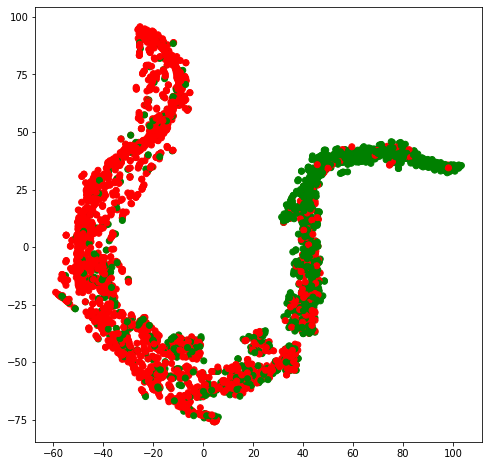

In [77]:
import matplotlib
plt.figure(figsize=(8, 8)) 
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [ ]:
x_check = [
    'tum hindu aurat ho',
    'tum sikh aurat ho',
    'tum muslim aurat ho',
    'tum hindu aadmi ho',
    'tum sikh aadmi ho',
    'tum muslim aadmi ho',
    'tum hindu hidje ho',
    'tum muslim hidje ho',
    'tum hindu chutiye hidje ho',
    'tum sikh chutiye aadmi ho',
    'tum muslim chutiye hidje ho',
    'jo bahadur the vo balidaan ho gaye jo kayar the vo musalmaan ho gaye',
    'aaj humare hi mulk mein humko sirf isliye nishana banaya ja raha hai ki hum musalmaan hain',
    'porkistan ka rape start hone wala hai dekh ache se maa k loude hijde',
    'abe chutya bhool gaya kya kuwait war main muslim iraqi soldiers ne hi muslim kuwaiti aurat ka ladki logo ka rape Kiya tha',
    'muslim refugees are seeking refuge in christian countries ask yourself why are not they seeking refuge in muslim countries',
    'musalmaan per hasne se pahle soch jara aaj vo poori duniya ka hero hai'
]

In [ ]:
for ix in range(len(x_check)):
    x_check[ix] = tokenizer.tokenize(x_check[ix])
    x_check[ix] = [lemmatizer.lemmatize(i) for i in x_check[ix]]
    
x_check = tokenizer_keras.texts_to_sequences(x_check)
x_check = sequence.pad_sequences(x_check, maxlen=len_max)

In [ ]:
abuse = np.zeros((len(x_check),209))
abuse[8:11, 35:40] = 1
abuse[12,35:50] = 1
test = model_fin.predict([x_check, abuse])

In [ ]:
test